In [85]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [3]:
RA: float = 11.7980
DEC: float = 85.2440

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [4]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/1_deg.csv', index_col=None)

In [5]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 2300138708529315712,2300138708529315712,662381376,2016.0,359.985190,0.082591,85.152716,0.076308,0.230850,...,0.0162,0.0037,0.0413,0.0129,0.0029,0.033,0.0070,0.0016,0.0180,PHOENIX
1,1636148068921376768,Gaia DR3 2300141663466822400,2300141663466822400,1219913963,2016.0,359.864403,0.184853,85.159847,0.178241,0.214223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636148068921376768,Gaia DR3 2300141667762951680,2300141667762951680,675368024,2016.0,359.912261,2.632776,85.157557,1.803413,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1636148068921376768,Gaia DR3 2300141938344743680,2300141938344743680,905723877,2016.0,359.893132,0.126966,85.175524,0.126572,0.401293,...,0.0116,0.0029,0.0301,0.0085,0.0021,0.022,0.0046,0.0011,0.0118,PHOENIX
4,1636148068921376768,Gaia DR3 2300142007064237952,2300142007064237952,365479039,2016.0,359.844342,0.623943,85.192913,0.546537,-0.602586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


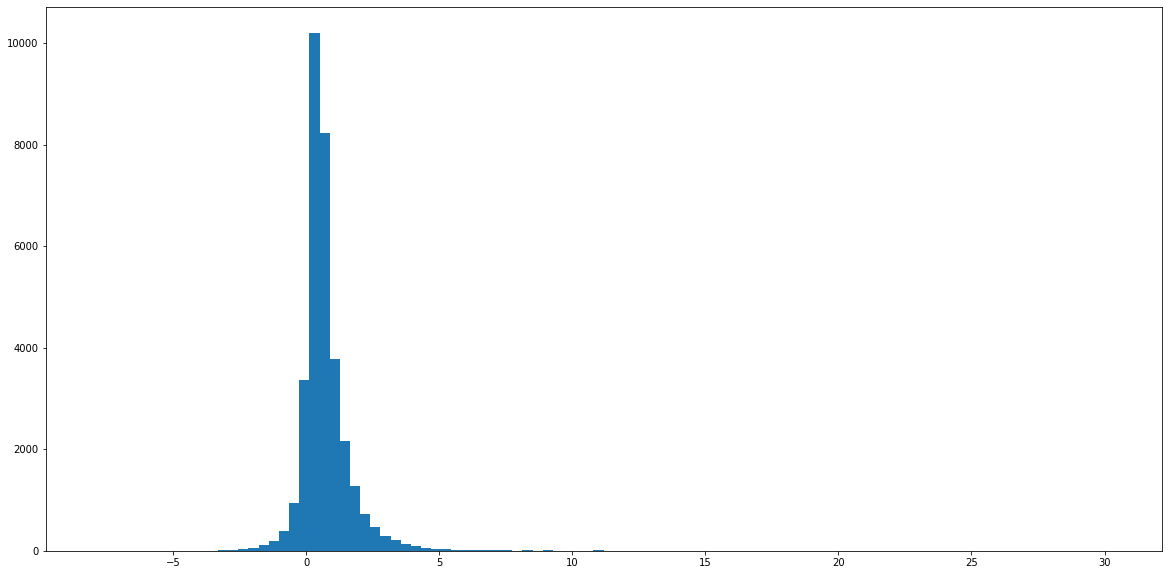

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(sources.parallax, bins=100);

# Preprocessing

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [106]:
def filter_by_parallax(sources: pd.DataFrame,
                       min_parallax: float,
                       max_parallax: float) -> pd.DataFrame:
    sources_par = sources[(sources['parallax']>min_parallax) & (sources['parallax']<max_parallax)]
    print(f'After parallax filtering: {len(sources_par)}')
    return sources_par

def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def 

In [107]:
sources_par = filter_by_parallax(sources, 0.25, 0.75)

After parallax filtering: 13684


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Scale the features to unit variance.

In [10]:
standard_scaler = StandardScaler()
sources_normalized = standard_scaler.fit_transform(sources_to_cluster)
sources_normalized

array([[-2.06761937e+00, -5.05041416e-02, -6.14113465e-01,
         3.47772224e-01,  4.46467054e-03],
       [-2.08254177e+00, -5.25038392e-03,  8.30391524e-01,
         6.26680237e-01, -1.25457160e+00],
       [-2.05259864e+00,  3.61575175e-02,  7.84960389e-01,
        -3.24267382e+00,  2.25392425e-01],
       ...,
       [-6.17105880e-01,  2.08591170e+00,  6.45329400e-02,
         4.34315593e-01, -3.58445244e-01],
       [-6.36210372e-01,  2.14908342e+00, -1.21565664e+00,
        -8.46906882e-01,  3.72523307e-01],
       [-6.01522496e-01,  2.15245750e+00, -2.40717219e-01,
         5.55101697e+00,  6.14964392e+00]])

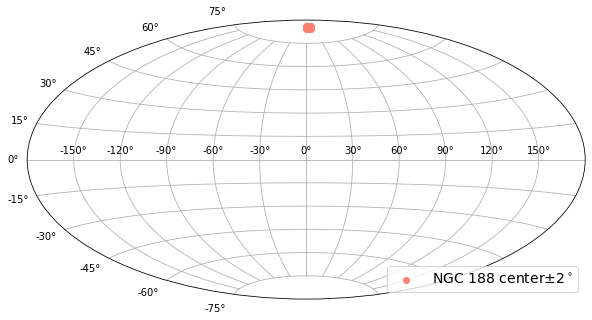

In [11]:
plt.figure(figsize=(10, 7));
plt.subplot(111, projection="aitoff");
plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon', label=r'NGC 188 center$\pm 2^\circ$');
plt.grid();
plt.legend(loc='lower right', fontsize=14);

# T-SNE visualization

In [87]:
sources_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(sources_normalized)

/home/mjablons/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


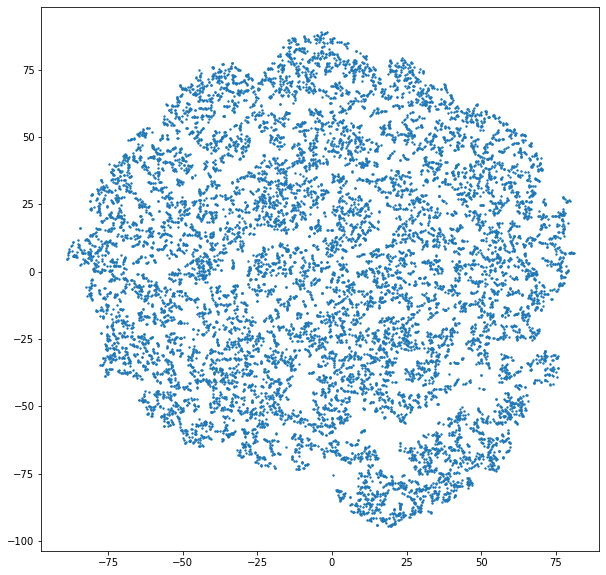

In [93]:
plt.figure(figsize=(10, 10))
plt.scatter(sources_embedded[:, 0], sources_embedded[:, 1], s=2.)

# DBSCAN

In [74]:
dbscan_clust = DBSCAN(eps=.4, min_samples=20)
dbscan_fit = dbscan_clust.fit(sources_normalized)

dbscan_labels = dbscan_fit.labels_
print(set(dbscan_labels))

{0, -1}


In [75]:
sources_labelled = pd.DataFrame(columns=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'label'],
                                data=np.concatenate([sources_to_cluster.values,
                                                     dbscan_labels.reshape((-1, 1))], axis=1))
sources_labelled['label'] = sources_labelled.label.astype(int)

In [76]:
sources_labelled.head()

,ra,dec,parallax,pmra,pmdec,label
0,-0.106868,85.175524,0.401293,1.235021,0.979092,-1
1,-0.192938,85.196739,0.593997,2.480786,-2.629402,-1
2,-0.020230,85.216151,0.587936,-14.802001,1.612288,-1
3,-0.075061,85.230875,0.283472,-2.839473,-2.467185,-1
4,-0.093472,85.234690,0.578207,-5.255996,-0.241723,-1


In [77]:
sources_cluster = sources_labelled[sources_labelled['label']==0]
print('Clustered:', len(sources_cluster))
sources_noise = sources_labelled[sources_labelled['label']!=0]
print('Noise:', len(sources_noise))

Clustered: 1375
Noise: 12309


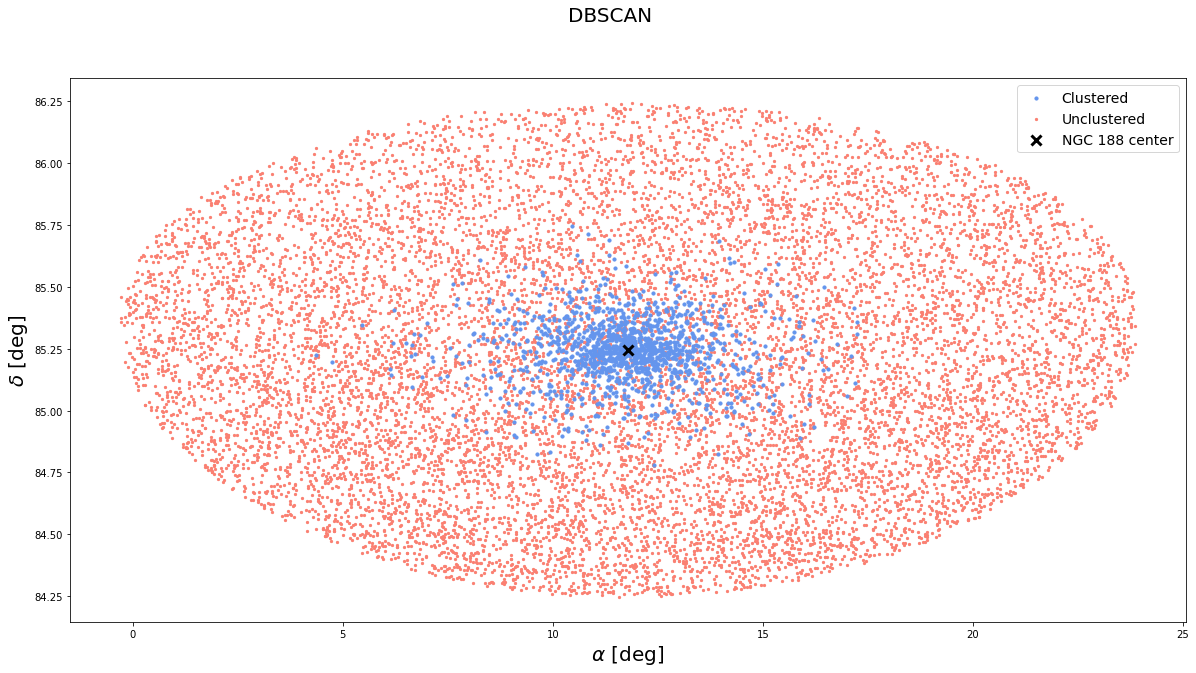

In [78]:
plt.figure(figsize=(20, 10))
plt.scatter(sources_cluster.ra, sources_cluster.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
plt.scatter(sources_noise.ra, sources_noise.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
plt.scatter(RA, DEC, marker='x', linewidths=3., zorder=3, s=100, color='black', label='NGC 188 center');
plt.legend(fontsize=14);
plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

plt.suptitle('DBSCAN', fontsize=20);

In [109]:
cluster_children: pd.DataFrame = fetch_object_children('NGC 188')

In [134]:
def is_in_cluster(source: np.array, cluster_coords: np.array) -> bool:
    return (np.any(np.isclose(source[0], cluster_coords[:, 0], rtol=1e-4)) and
            np.any(np.isclose(source[1], cluster_coords[:, 1], rtol=1e-4)))

In [135]:
def check_for_cluster_children(cluster_children: pd.DataFrame,
                               sources_cluster: pd.DataFrame) -> bool:
    cluster_children_coords = np.unique(cluster_children.values[:, [1, 2]].astype(float), axis=0)
    sources_coords = sources_cluster.values[:, [0, 1]]
    
    in_cluster = np.array(list(map(lambda x: is_in_cluster(x, sources_coords), cluster_children_coords)))
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return len(trues)/len(in_cluster)

In [136]:
r = check_for_cluster_children(cluster_children, sources_cluster)

1257/1624 objects found in the cluster.


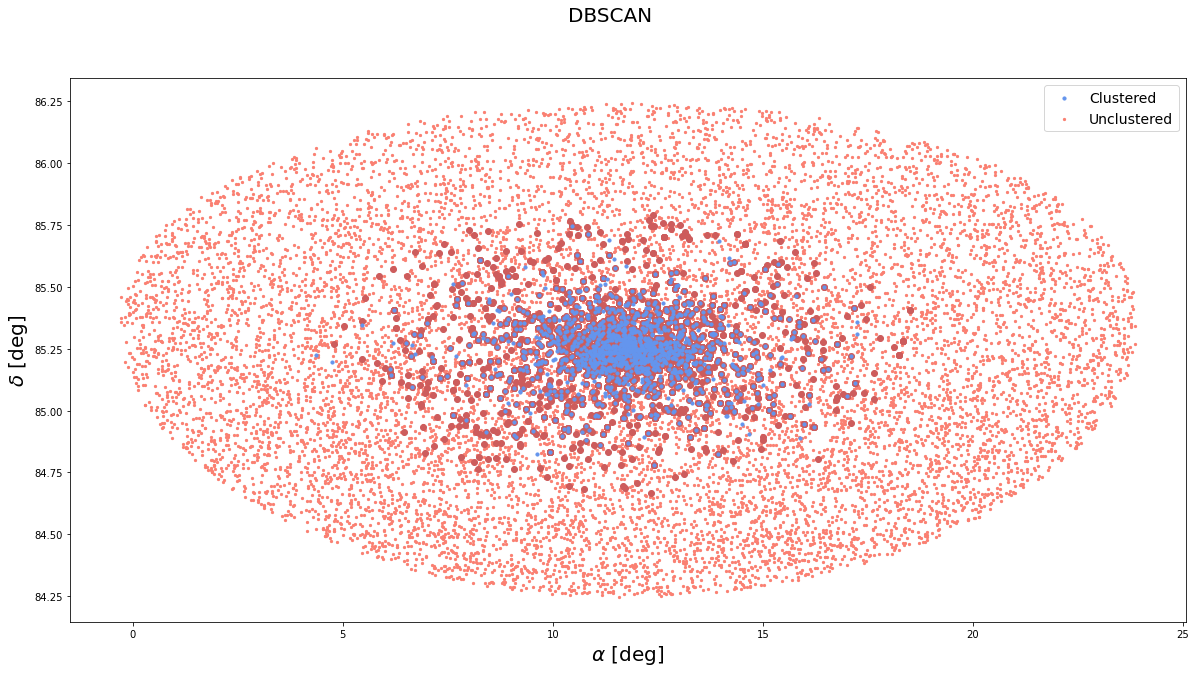

In [137]:
plt.figure(figsize=(20, 10))
plt.scatter(sources_cluster.ra, sources_cluster.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
plt.scatter(sources_noise.ra, sources_noise.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
plt.scatter(cluster_children.ra, cluster_children.dec, color='indianred', zorder=1)
plt.legend(fontsize=14);
plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

plt.suptitle('DBSCAN', fontsize=20);

# HDBSCAN